In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.wsd import lesk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,label_binarize
from itertools import cycle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve, auc
from sklearn.naive_bayes import MultinomialNB,ComplementNB
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from imblearn.under_sampling import RandomUnderSampler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)

True

In [2]:
#thsi code is used to hide the warning messages
pd.options.mode.chained_assignment = None

## Exploratory Data Analysis

In [ ]:
df=pd.read_csv('Tweets.csv')
df.head()

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

Require column for model don't have null values , so we are not going to fill null values.

In [ ]:
df_sorted = df.sort_values('airline_sentiment')
order=['negative','neutral','positive']
sns.countplot(x='airline_sentiment',data=df,order=order,palette='Set1')
plt.show()

Negative tweet count is much higher than neutral and positive

In [4]:
#selecting only columns needed for sentiment analysis
df_sa=df[['airline_sentiment','text']]
df_sa.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [8]:
tweet_leanght=df['text'].apply(len)
print(f'min={min(tweet_leanght)},mean={round(np.mean(tweet_leanght))},max={max(tweet_leanght)}')

min=12,mean=104,max=186


In [5]:
#defining a function to clean the tweets
def preprocessing(text):
    #remove url
    text=re.sub(r'http\S+|www\S+|https\S+','',text,flags=re.MULTILINE)
    #remove user @ references and '#' from tweet
    text=re.sub(r'\@\w+|\#','',text)
    #removing every thing expect alphbets
    text=re.sub(r'[^a-zA-Z]',' ',text)
    
    text=text.lower()
    tokenized_text=word_tokenize(text)
    
    #remove stopwords
    stopword=stopwords.words('english')
    tokenized_text=[word for word in tokenized_text if word not in stopword]
    
    # lematizing the words
    lem=WordNetLemmatizer()
    tokenized_text=[lem.lemmatize(word) for word in tokenized_text]
    
    #using lest to diambuiguate the words
    tokenized_text = [
    (lesk(tokenized_text, word).lemmas()[0].name()
    if lesk(tokenized_text, word) else word)
    for word in tokenized_text
    ]
    
    text=' '.join(tokenized_text)
    return text

In [6]:
df_sa['text']=df_sa['text'].apply(preprocessing)
#df_sa.head()

In [91]:
count=sum(df_sa['text'].apply(len))
count

915946

### Now we will Create model for Sentiment analysis

In [154]:
df_sa['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [7]:
x=df_sa['text']
y=df_sa['airline_sentiment']

In [8]:
#comment tfidf for running nueral network
verctorizer=TfidfVectorizer(max_features=18000)
x=verctorizer.fit_transform(x)

LabelEncoder_y=LabelEncoder()
y=LabelEncoder_y.fit_transform(y)


accuracey with all preprocessing steps ,smote and complement naive bayes=79,MultinomialNB=78
adjusting hyperparameter in cNA results by 1 point

adjusting word count in tfidf improving results maybe work in progress 18000 give best results 80-81% accuracey


accuracey when not using disambiguate is almost same

changing lematize with stemer reduce accuracey

Try nural network with embedding layer




In [16]:
# Oversample the minority classes(positive and neutral) using SMOTE
method = SMOTE()

# Create the resampled feature set
x, y = method.fit_resample(x, y)

In [ ]:
#Eithor use this or the above code

# Instantiate the RandomUnderSampler method
undersample = RandomUnderSampler()

# Create the resampled feature set
x, y = undersample.fit_resample(x, y)

In [17]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=28)

In [18]:
classifier=ComplementNB(alpha=0.5, fit_prior=True, class_prior=None,norm=False)
classifier.fit(x_train,y_train)
y_pred=classifier.predict(x_test)

print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.76      0.84      0.80      1758
           1       0.83      0.70      0.76      1915
           2       0.84      0.89      0.87      1834

    accuracy                           0.81      5507
   macro avg       0.81      0.81      0.81      5507
weighted avg       0.81      0.81      0.81      5507



In [19]:
classifier2=MultinomialNB(alpha=0.5, fit_prior=False, class_prior=None)
classifier2.fit(x_train,y_train)
y_pred=classifier2.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.83      0.79      1758
           1       0.80      0.72      0.76      1915
           2       0.86      0.87      0.87      1834

    accuracy                           0.81      5507
   macro avg       0.81      0.81      0.80      5507
weighted avg       0.81      0.81      0.80      5507



In [21]:
def apply_model(model, params, x_train, y_train, x_test, y_test):
    grid_search = GridSearchCV(model, params, cv=5)
    grid_search.fit(x_train, y_train)
    y_pred = grid_search.predict(x_test)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Classification report:\n{classification_report(y_test, y_pred)}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")

In [23]:
# SVM
print("SVM:")
apply_model(svm.SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}, x_train, y_train, x_test, y_test)

# Random Forest
print("Random Forest:")
apply_model(RandomForestClassifier(), {'n_estimators': [100, 200, 500], 'max_depth': [None, 10, 20, 30]}, x_train, y_train, x_test, y_test)

# Logistic Regression
print("Logistic Regression:")
apply_model(LogisticRegression(), {'C': [0.1, 1, 10]}, x_train, y_train, x_test, y_test)

SVM:
Best parameters: {'C': 10, 'kernel': 'rbf'}
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1758
           1       0.87      0.88      0.87      1915
           2       0.93      0.88      0.91      1834

    accuracy                           0.89      5507
   macro avg       0.90      0.90      0.90      5507
weighted avg       0.90      0.89      0.89      5507

Accuracy: 0.894679498819684

Random Forest:


In [ ]:
classifier3=svm.SVC(C=10,kernel='rbf')
classifier3.fit(x_train,y_train)
y_pred=classifier3.predict(x_test)

print(classification_report(y_test,y_pred))

In [185]:
#Creating Tokenizer
tokenizer =keras.preprocessing.text.Tokenizer(num_words=18000)
tokenizer.fit_on_texts(x_train)

#Converting text to sequence integers
X_train=tokenizer.texts_to_sequences(x_train)
X_test=tokenizer.texts_to_sequences(x_test)

# Pad sequences to ensure they have the same length
max_sequence_length=100
X_train=keras.preprocessing.sequence.pad_sequences(X_train,maxlen=max_sequence_length, padding='post', truncating='post')
X_test=keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_sequence_length, padding='post', truncating='post')

In [190]:
#creating nureal network
#Embedding layer used to learn and represent words or categorical data in a continuous, lower-dimensional space especially used in NLP.
model = keras.Sequential([
    keras.layers.Embedding(input_dim=18000, output_dim=32),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])


#Binary Cross-Entropy = - [y * log(p) + (1 - y) * log(1 - p)] >>y true label(0,1) , p is predicted probability
#This loss function is used for binary classification especially with sigmoid

In [ ]:
model.fit(X_train,y_train,epochs=50,validation_data=(X_test,y_test))

In [192]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

92/92 [==============================] - 0s 2ms/step - loss: -398952.8750 - accuracy: 0.6130
Test Accuracy: 0.6130464673042297


In [159]:
def predict_sentiment(text):
    text=preprocessing(text)
    text=verctorizer.transform([text])
    sentiment=classifier.predict(text)
    sentiment=LabelEncoder_y.inverse_transform(sentiment)
    return sentiment

In [168]:
def plot_probabilities(text):
    text=preprocessing(text)
    text=verctorizer.transform([text])
    probabilities=classifier.predict_proba(text)
    labels = LabelEncoder_y.classes_
    index = np.arange(len(labels))
    plt.bar(index, probabilities[0])
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.xticks(index, labels, rotation=30)
    plt.title('Probability of Each Class')
    plt.show()

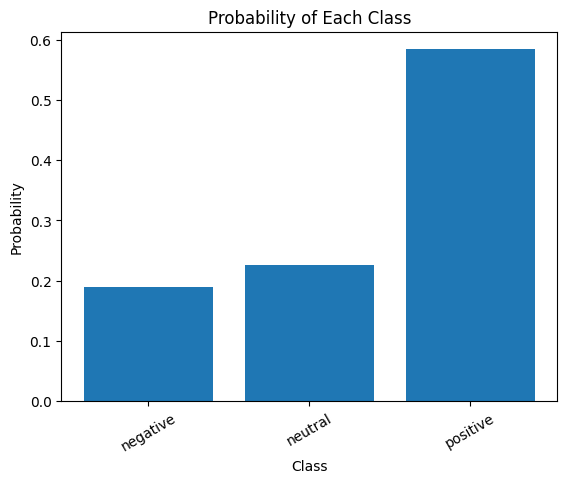

None


In [172]:
text="@virginamerica Well, I didn'tâ€¦but NOW I DO! :-D"
print(plot_probabilities(text))